In [1]:
import os
from glob import glob
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches

from cascade.learning.torchani import TorchANI
from pathlib import Path
from ase.io import read
from ase import units
import pickle as pkl
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
run_dirs = sorted(glob('runs/800K-npt-single-train/si*temp=*00*blend*'))
run_dirs

['runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-00e6f7df',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-05bd7fef',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-0aff6fba',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-105292bb',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1418cfda',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-160f5dc6',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1ffe8b75',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-24aacf2b',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-2fc33503',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-399f3417',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-3c135b25',
 'runs/800K-npt-single-train/si-vacancy-2x2

In [3]:
run_dirs = [d for d in run_dirs if 'blend=20' not in d]

In [4]:
params = []
for d in run_dirs:
    try:
        params.append(json.loads((Path(d)/'params.json').read_text()))
    except: 
        print(f'couldnt find {d}/params.json; skipping')
        continue
    params[-1]['dir'] = d
params = pd.DataFrame(params)
params.shape

(78, 30)

In [5]:
params = params.query('min_target_frac == 0.1 or min_target_frac == 1')
params = params.query('n_blending_steps == 0 or n_blending_steps == 10')
params = params.query('target_error != 0.45')

In [6]:
meth = []
for i, row in params.iterrows():
    if row['n_blending_steps'] == 0 and row['min_target_frac'] == 1:
        meth.append('DFT (reference)')
    elif row['n_blending_steps'] == 0: 
        meth.append('Proxima')
    else: 
        meth.append('Proxima+blend')
params['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima+blend', 'DFT (reference)'])

In [7]:
param_vars = ['seed', 'temperature', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps']
_params = params[param_vars].sort_values(param_vars)
_params.describe()

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps
count,18.000000,18.0,18.000000,18.000000,1.800000e+01,18.0,18.0
mean,2.500000,800.0,3.333333,0.400000,6.000000e-01,25.0,2048.0
std,1.757338,0.0,4.850713,0.436564,4.365641e-01,0.0,0.0
min,0.000000,800.0,0.000000,0.100000,1.000000e-12,25.0,2048.0
25%,1.000000,800.0,0.000000,0.100000,1.000000e-12,25.0,2048.0
50%,2.500000,800.0,0.000000,0.100000,9.000000e-01,25.0,2048.0
75%,4.000000,800.0,10.000000,1.000000,9.000000e-01,25.0,2048.0
max,5.000000,800.0,10.000000,1.000000,9.000000e-01,25.0,2048.0


In [8]:
_params

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps
15,0,800.0,0,0.1,9.000000e-01,25.0,2048
4,0,800.0,0,1.0,1.000000e-12,25.0,2048
77,0,800.0,10,0.1,9.000000e-01,25.0,2048
35,1,800.0,0,0.1,9.000000e-01,25.0,2048
14,1,800.0,0,1.0,1.000000e-12,25.0,2048
46,1,800.0,10,0.1,9.000000e-01,25.0,2048
3,2,800.0,0,0.1,9.000000e-01,25.0,2048
18,2,800.0,0,1.0,1.000000e-12,25.0,2048
44,2,800.0,10,0.1,9.000000e-01,25.0,2048
20,3,800.0,0,0.1,9.000000e-01,25.0,2048


In [9]:
assert not _params.duplicated().any()

## Read all of the trajectory data into one dataframe

In [10]:
data = []
hashes = []
for i, row in params.iterrows(): 
    # read in the results for each set of parameters
    run = row['dir']
    try:
        _data = pd.read_json(Path(run)/'proxima-log.json', lines=True)
    except: 
        print('couldnt read proxima log for', run)
        hashes.append(None)
        continue
    # make sure to have timestep
    _data.reset_index(names='timestep', inplace=True)

    # keep the hash of the run
    _hash = run.split('-')[-1]
    hashes.append(_hash)
    _data['hash'] = _hash 
    #traj = read(Path(run)/'md.traj', index=':')
    #break    
    # add the parameters to the experiment df for easy plotting, grouping, etc
    for var in param_vars:
        _data[var] = row[var]
    data.append(_data)

# track the hashes as well for param lookup
params['hash'] = hashes
data = pd.concat(data)

## add method 

In [11]:
meth = []
for i, row in params.iterrows():
    if row['n_blending_steps'] == 0 and row['min_target_frac'] == 1:
        meth.append('DFT (reference)')
    elif row['n_blending_steps'] == 0: 
        meth.append('Proxima')
    else: 
        meth.append('Proxima+blend')
params['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima+blend', 'DFT (reference)'])

In [12]:
data = pd.merge(data, params[['hash', 'Method']], on='hash', how='left')

## merge data and params

In [13]:
data

,timestep,step_time,energy,maximum_force,stress,temperature,volume,used_surrogate,proxima_alpha,proxima_threshold,proxima_blending_step,proxima_lambda_target,last_uncer,last_error,total_invocations,target_invocations,model_version,hash,seed,n_blending_steps,min_target_frac,target_error,stress_tau,steps,Method
0,0,8.517287,-6683.999990,0.616292,"[-0.034178451488095, -0.034089589941489, -0.03...",800.0,1280.824056,False,NaN,NaN,0,NaN,0.026653,0.621075,2,2,0,0aff6fba,4,0,0.1,0.9,25.0,2048,Proxima
1,1,5.156654,-6683.916856,0.856425,"[-0.033986991206128005, -0.033826269874489, -0...",800.0,1281.570358,False,NaN,NaN,0,NaN,0.027269,0.859439,3,3,0,0aff6fba,4,0,0.1,0.9,25.0,2048,Proxima
2,2,4.565278,-6683.765573,1.090278,"[-0.033848412566292, -0.033631905743538006, -0...",800.0,1282.319134,False,NaN,NaN,0,NaN,0.027785,1.091607,4,4,0,0aff6fba,4,0,0.1,0.9,25.0,2048,Proxima
3,3,4.979567,-6683.576759,1.314290,"[-0.033358446995748005, -0.033104908683742, -0...",800.0,1283.801296,False,NaN,NaN,0,NaN,0.028210,1.314065,5,5,0,0aff6fba,4,0,0.1,0.9,25.0,2048,Proxima
4,4,5.023417,-6683.334164,1.527470,"[-0.032904060174518, -0.03263028678802, -0.032...",800.0,1285.290604,False,NaN,NaN,0,NaN,0.028527,1.525833,6,6,0,0aff6fba,4,0,0.1,0.9,25.0,2048,Proxima
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36859,2043,0.085000,-6680.638087,3.155559,"[-0.00035896169720200005, -0.013680156320333, ...",800.0,1340.010219,True,21.050366,0.294774,10,0.0,0.045739,3.634163,3011,1415,1,ffe10d1f,0,10,0.1,0.9,25.0,2048,Proxima+blend
36860,2044,0.262504,-6680.645056,3.212494,"[9.378482354804875e-05, -0.013247493654489, -0...",800.0,1341.089242,True,21.050366,0.294774,10,0.0,0.045739,3.634163,3013,1415,1,ffe10d1f,0,10,0.1,0.9,25.0,2048,Proxima+blend
36861,2045,0.272498,-6680.652195,3.230515,"[0.0008289217948910001, -0.012591516599059, -0...",800.0,1342.821368,True,21.050366,0.294774,10,0.0,0.045739,3.634163,3015,1415,1,ffe10d1f,0,10,0.1,0.9,25.0,2048,Proxima+blend
36862,2046,0.084999,-6680.653661,3.212458,"[0.001265179831534, -0.012153295800089002, -0....",800.0,1343.957491,True,21.050366,0.294774,10,0.0,0.045739,3.634163,3017,1415,1,ffe10d1f,0,10,0.1,0.9,25.0,2048,Proxima+blend


## update used surrogate

In [14]:
data['used_surrogate'].value_counts()

used_surrogate
False    29349
True      7515
Name: count, dtype: int64

In [15]:
data['used_surrogate'].isna().any()

False

In [16]:
data['proxima_blending_step'].value_counts()

proxima_blending_step
0     31802
10     4153
9       460
8       127
4        81
6        77
2        70
7        31
5        28
3        19
1        16
Name: count, dtype: int64

In [17]:
data['proxima_blending_step'].isna().any()

False

In [18]:
data['n_blending_steps'].isna().any()

False

In [19]:
?np.where

Call signature:  np.where(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <built-in function where>
Docstring:      
where(condition, [x, y], /)

Return elements chosen from `x` or `y` depending on `condition`.

.. note::
    When only `condition` is provided, this function is a shorthand for
    ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
    preferred, as it behaves correctly for subclasses. The rest of this
    documentation covers only the case where all three arguments are
    provided.

Parameters
----------
condition : array_like, bool
    Where True, yield `x`, otherwise yield `y`.
x, y : array_like
    Values from which to choose. `x`, `y` and `condition` need to be
    broadcastable to some shape.

Returns
-------
out : ndarray
    An array with elements from `x` where `condition` is True, and elements
    from `y` elsewhere.

See Also
--------
choose
nonzero : The function that is called when x and y are omitted

Notes


In [20]:
params['my_commit'].unique()

array(['884fa037daca2f12f3c528117ba8a386033dfd71'], dtype=object)

In [21]:
data['full_surrogate'] = np.where(data['n_blending_steps'] == 0, data['used_surrogate'], (data['proxima_blending_step'] == data['n_blending_steps']) & data['used_surrogate'])

In [22]:
data['training_step'] = data['model_version'].diff() > 0

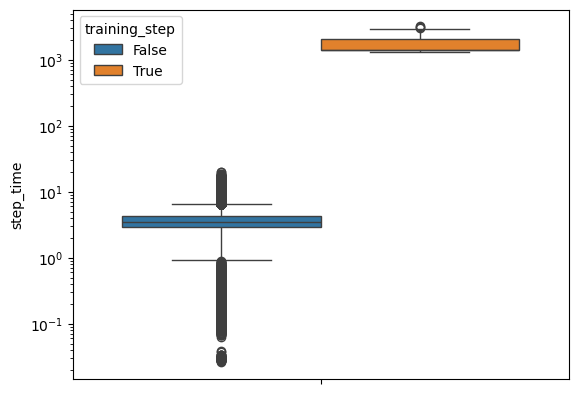

In [23]:
sns.boxplot(
    y='step_time',
    hue='training_step',
    data=data
)
plt.yscale('log')
plt.show()

In [24]:
data['Method'].value_counts() / 2048

Method
Proxima            6.0
Proxima+blend      6.0
DFT (reference)    6.0
Name: count, dtype: float64

In [25]:
data.query('training_step == False').groupby('full_surrogate')[['step_time']].mean()

,step_time
full_surrogate,
False,3.993548
True,1.049921


In [26]:
data.query('training_step == False').groupby('full_surrogate')[['step_time']].median()

,step_time
full_surrogate,
False,3.62637
True,0.21014


In [27]:
data.query('training_step == False').groupby('full_surrogate')[['step_time']].std()

,step_time
full_surrogate,
False,1.480686
True,2.251837


In [28]:
data.query('training_step == True')[['step_time']].mean()

step_time    1825.265144
dtype: float64

In [29]:
data.query('training_step == True')[['step_time']].mean() / 60

step_time    30.421086
dtype: float64

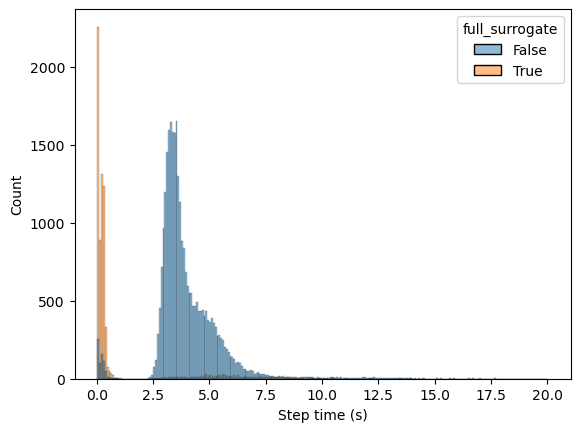

In [30]:
ax = sns.histplot(
    x='step_time',
    hue='full_surrogate',
    data=data.query('training_step == False'),
    #log_scale=(True, False)
)
#plt.yscale('log') # (True, True) breaks the above
plt.xlabel('Step time (s)')
#ax.legend.set_title('Used Surrogate')
plt.show()

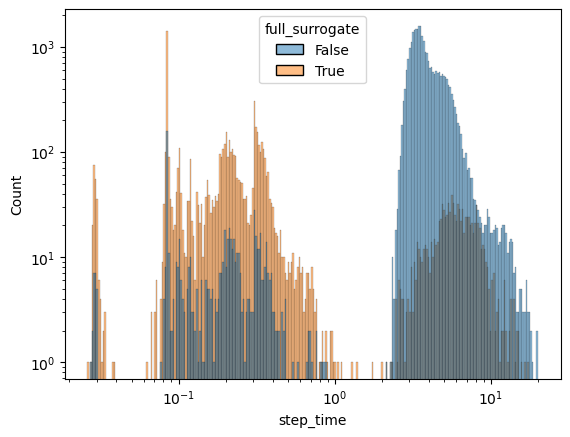

In [31]:
sns.histplot(
    x='step_time',
    hue='full_surrogate',
    data=data.query('training_step == False'),
    log_scale=(True, False)
)
plt.yscale('log') # (True, True) breaks the above
plt.show()

In [32]:
means = data.query('training_step == False').groupby('full_surrogate')[['step_time']].mean()
means

,step_time
full_surrogate,
False,3.993548
True,1.049921


In [33]:
means / means.iloc[1]

,step_time
full_surrogate,
False,3.803667
True,1.000000


In [34]:
data.query('full_surrogate == False').hash.value_counts()

hash
7c306fa4    2048
6a2330a6    2048
1418cfda    2048
3c135b25    2048
df641e0d    2048
4e1470ea    2048
0aff6fba    1757
4202e855    1565
842df0f8    1535
e4161130    1533
105292bb    1503
741e74e4    1501
15ddd631    1427
0a8231d9    1340
5271547c    1323
06819c7d    1310
9bd27cec    1278
ffe10d1f    1245
Name: count, dtype: int64

In [35]:
data.query('full_surrogate == False and step_time < .1')[param_vars + ['hash', 'Method']].drop_duplicates()

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps,hash,Method
1132,4,800.0,0,0.1,0.9,25.0,2048,0aff6fba,Proxima
3194,2,800.0,0,0.1,0.9,25.0,2048,105292bb,Proxima
9263,5,800.0,0,0.1,0.9,25.0,2048,4202e855,Proxima
13359,0,800.0,0,0.1,0.9,25.0,2048,5271547c,Proxima
17634,3,800.0,0,0.1,0.9,25.0,2048,741e74e4,Proxima
23649,1,800.0,0,0.1,0.9,25.0,2048,e4161130,Proxima
25733,4,800.0,10,0.1,0.9,25.0,2048,06819c7d,Proxima+blend
27749,2,800.0,10,0.1,0.9,25.0,2048,0a8231d9,Proxima+blend
29772,1,800.0,10,0.1,0.9,25.0,2048,15ddd631,Proxima+blend
31791,5,800.0,10,0.1,0.9,25.0,2048,842df0f8,Proxima+blend


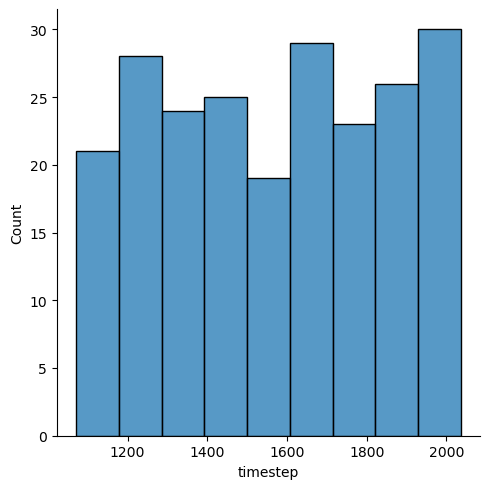

In [36]:
sns.displot(data.query('full_surrogate == False and step_time < 0.1')['timestep'])
#plt.yscale('log')
plt.show()

In [37]:
data.query('full_surrogate == False and step_time < 1')['model_version'].unique()

array([1])

In [38]:
data.query('full_surrogate == False and step_time < 1').hash.value_counts()

hash
9bd27cec    76
ffe10d1f    71
15ddd631    64
e4161130    63
5271547c    62
0a8231d9    62
105292bb    60
06819c7d    55
741e74e4    52
4202e855    50
842df0f8    50
0aff6fba    37
Name: count, dtype: int64

## drop questionable data
We still need to sort out why the times to not make sense, but we can drop the few that are causing issues

In [39]:
_data = data.query('training_step == False')

n = _data.shape[0]
n_dft = _data.query('full_surrogate == False').shape[0]
n_ml  = _data.query('full_surrogate == True').shape[0]

dft_too_fast = (~_data['full_surrogate']) & (_data['step_time'] < 1)
ml_too_slow =  (_data['full_surrogate'])  & (_data['step_time'] > 1)

n_too_fast = dft_too_fast.sum()
n_too_slow = ml_too_slow.sum()

_data = _data[~(dft_too_fast | ml_too_slow)]

In [40]:
n, n_dft, n_ml

(36840, 29581, 7259)

In [41]:
n_dft + n_ml == n

True

In [42]:
n_too_fast, (n_too_fast / n_dft) * 100

(702, 2.37314492410669)

In [43]:
n_too_slow, (n_too_slow / n_ml) * 100

(1035, 14.258162281305964)

In [44]:
(n_too_fast + n_too_slow) / n

0.04714983713355049

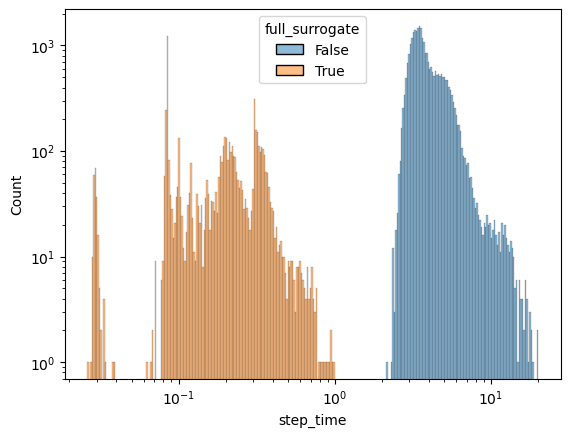

In [45]:
sns.histplot(
    x='step_time',
    hue='full_surrogate',
    data=_data,
    log_scale=(True, False)
)
plt.yscale('log') # (True, True) breaks the above
plt.show()

In [69]:
means = _data.groupby('full_surrogate')['step_time'].mean()
means

full_surrogate
False    4.085725
True     0.200870
Name: step_time, dtype: float64

In [72]:
means / means.iloc[1]

full_surrogate
False    20.340152
True      1.000000
Name: step_time, dtype: float64

In [94]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [95]:
means = _data.groupby('full_surrogate').agg({
    'step_time': ['mean', 'median', 'std', 'min', 'max', percentile(0.25), percentile(0.75)]
})
means

step_time                                                                     
                    mean    median       std       min        max percentile_25 percentile_75
full_surrogate                                                                               
False           4.085725  3.650540  1.373778  2.140161  20.043883      3.267311      4.556687
True            0.200870  0.190296  0.125296  0.025997   0.985810      0.085001      0.305535

## dft only runtimes

In [81]:
params.columns

Index(['file', 'starting_strc', 'temperature', 'timestep', 'calculator', 'ensemble', 'temp_tau', 'stress_tau', 'steps', 'seed', 'bulk_modulus', 'model_type', 'initial_model', 'initial_data', 'ensemble_size', 'online_training', 'training_epochs', 'training_batch_size', 'training_max_size', 'training_recency_bias', 'training_device', 'target_error', 'error_history', 'retrain_freq', 'min_target_frac', 'n_blending_steps', 'cascade_commit', 'my_commit', 'start_time', 'dir', 'Method', 'hash'], dtype='object')

In [82]:
data.columns

Index(['timestep', 'step_time', 'energy', 'maximum_force', 'stress', 'temperature', 'volume', 'used_surrogate', 'proxima_alpha', 'proxima_threshold', 'proxima_blending_step', 'proxima_lambda_target', 'last_uncer', 'last_error', 'total_invocations', 'target_invocations', 'model_version', 'hash', 'seed', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps', 'Method', 'full_surrogate', 'training_step'], dtype='object')

In [86]:
data.query('Method == "DFT (reference)"').groupby('hash')['step_time'].sum() / (60*60)

hash
1418cfda    3.392728
3c135b25    3.287104
4e1470ea    3.505526
6a2330a6    3.359071
7c306fa4    3.405820
df641e0d    3.506428
Name: step_time, dtype: float64

In [ ]:
dft_only = a